## 1. Construct a signal with high-frequency noise

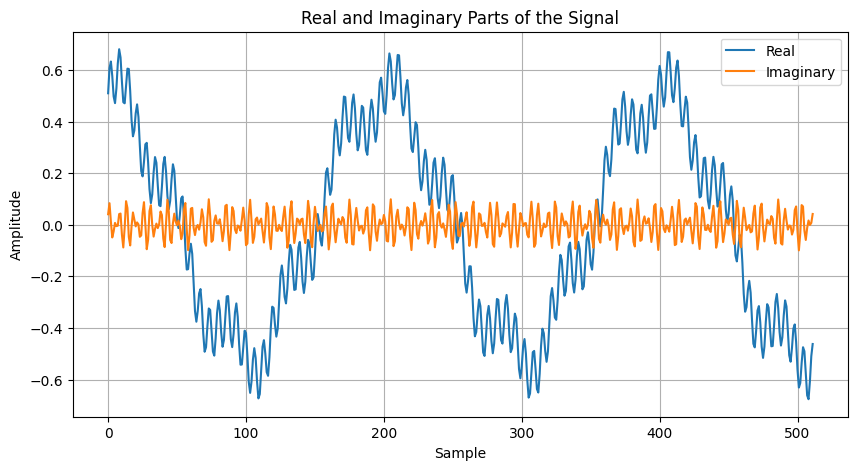

In [4]:
import numpy as np
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../common/')
from aie_signals import SignalPlotter
from aie_signals import SignalGenerator

sample_rate = 100.0
nsamples = 1024

def generate_signal_cmpx(samples = 1024, fs = 100):
    f0, f1, f2, f3, f4 = 0.5, 2.5, 15.3, 16.7, 23.45
    ts = 1 / fs
    time = np.linspace(0, samples*ts, samples)

    tone_0 = 1 * np.cos(2*np.pi*f0*time)
    tone_1 = 0.2 * np.sin(2*np.pi*f1*time+0.1)
    tone_2 = 0.2 * np.sin(2*np.pi*f2*time)
    tone_3 = 0.1 * np.sin(2*np.pi*f3*time+0.1)
    tone_4 = 0.1 * np.sin(2*np.pi*f4*time+0.8)
    signal = (tone_0 + tone_1 + tone_2*1 + tone_3*1j + tone_4*1j)/2
    return signal,time

# Plot the real part of the signal

signal, time = generate_signal_cmpx(nsamples, sample_rate)
plotter = SignalPlotter(signal)
plotter.plot_real_imaginary(512)


## 2. Create a FIR Low Pass filter

In [5]:
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# Set the desired filter length
desired_length = 16

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
# N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

N, beta = kaiserord(ripple_db, width)

# Use firwin with a Kaiser window to create a lowpass FIR filter.
lpf_coeffs = (firwin(desired_length, cutoff_hz/nyq_rate, window=('kaiser', beta))).astype(np.float32)

# Calculate the sum of the filter coefficients
coeffs_sum = np.sum(lpf_coeffs)

# calculate the scaling factor
scaling_factor = (2**15 - 1) / coeffs_sum

# Perform weighted quantization of the coefficients
lpf_coeffs_hw = np.round(lpf_coeffs * scaling_factor).astype(np.int16)

# Ensure the sum of the coefficients is less than 2^15
quantized_coeffs_sum = np.sum(lpf_coeffs_hw)
if quantized_coeffs_sum > (2**15 - 1):
    lpf_coeffs_hw = (lpf_coeffs_hw * (2**15 - 1) / quantized_coeffs_sum).astype(np.int16)

filter_len= len(lpf_coeffs_hw)

print('compute_len =',N)
print('filter_len =',filter_len)
print(lpf_coeffs_hw)

compute_len = 74
filter_len = 16
[ -29 -115 -122  268 1379 3209 5226 6566 6566 5226 3209 1379  268 -122
 -115  -29]


## 3. Plot the FIR filter coefficients

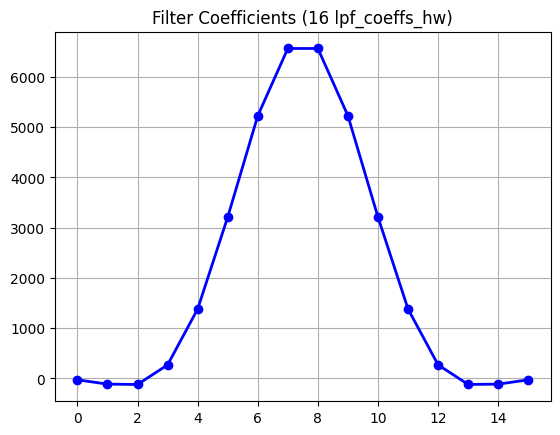

In [6]:
figure(1)
plot(lpf_coeffs_hw, 'bo-', linewidth=2)
title('Filter Coefficients (%d lpf_coeffs_hw)' % filter_len)
grid(True)


The signals are quantified according to the requirements and generated into the format required by AIE

## 4. Generate the input vector file

In [7]:
from aie_file import FileGen
FileGen.vector2file_cint16(signal, './data/input.txt', scale=True)

32768

Plot the magnitude response of the filter.

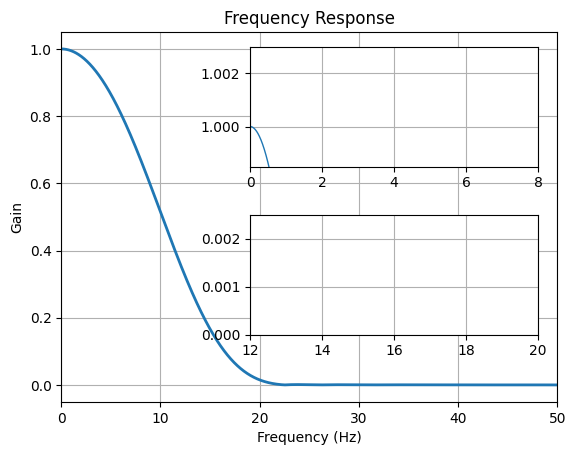

In [8]:
figure(2)
clf()
w, h = freqz(lpf_coeffs, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
xlim(0,50)
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(0,8)
ylim(0.9985, 1.003)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

## 5. Apply the filter to signal using lfilter and Plot the original and software filtered signals

Input Signal


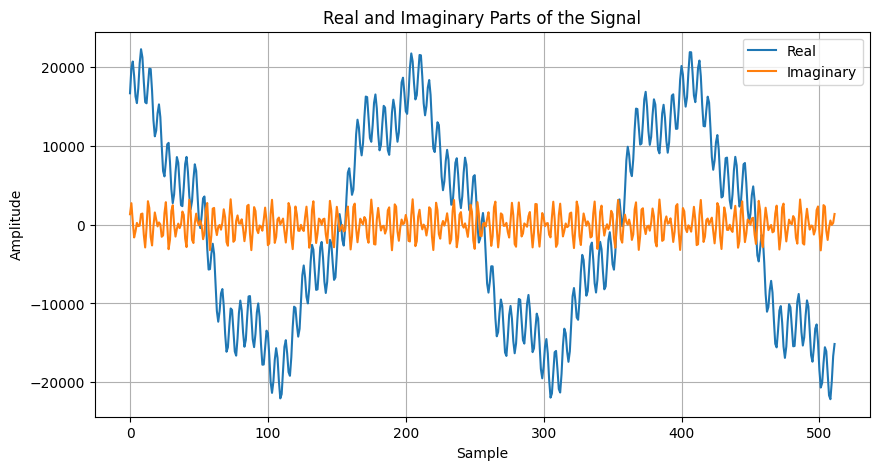

SW filtered signal


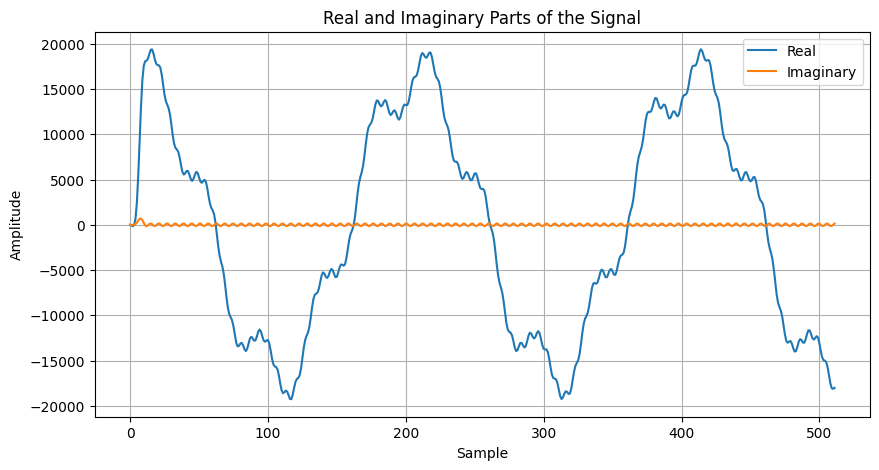

32764

In [10]:
input_data = FileGen().read_file('./data/input.txt', 1024)
lpf_coeffs_hw = [ -29, -115, -122, 268, 1379, 3209, 5226, 6566, 6566, 5226, 3209, 1379,  268, -122, -115, -29]

filtered_signal = lfilter(lpf_coeffs_hw, 1.0, input_data)
SW_filtered_signal = np.round(filtered_signal * (2 ** -15))

FileGen.write_refoutput(SW_filtered_signal, './data/output_golden.txt', scale=True)

print("Input Signal")
plotter = SignalPlotter(input_data)
plotter.plot_real_imaginary(512)

print("SW filtered signal")
plotter = SignalPlotter(SW_filtered_signal)
plotter.plot_real_imaginary(512)

sum(lpf_coeffs_hw)

## 6. Apply the filter to signal using AIE and Plot the original and filtered signals

### Step1: Analyze the design requirement

| Symmetric | Tap - Points   |  CoeffType   | DataType | Samples |
|--------|---------|----------|--------------|--------|
|   Yes  | 16 | int16  | int16 | 1024 |

### Step 2: Select the interface type, vector data type and memory unit according to the AIE computing capability

1. What is the number of MAC operations varies based on the data type? 

To calculate the maximum performance for a given data path, it is necessary to multiply the number of MACs per instruction by the clock frequency of the AI Engine kernel. 

In this example, with 16-bit input vectors X(data) and Z(coefficient), the vector processor can achieve 32 MACs per instruction. Using the clock frequency for the slowest speed grade results in:
32 MACs * 1 GHz clock frequency = 32 Giga MAC operations/second.

<!-- 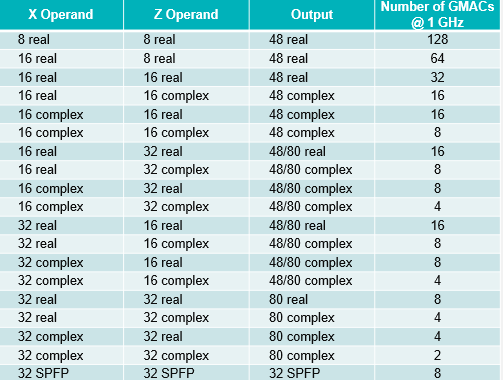 -->

2. Which AIE API is the best suitable for this FIR application?

using mulop = aie::sliding_mul_sym_xy_ops<Lanes, Points, CoeffStep, DataStepXY,int16,int16>;

3. How to choose the number of points and lanes per clock cycle? 

4. How to choose the proper vector data type?

5. How to set the vector buffer size according to vector data type and register file? 
6. What's the relationship between lane and samples?

![data_flow](../../image/fir_excel_16taps.png)


### Step 3: AIE Source code analysis

```C++
void fir_16taps_symm // _single_buf_array_indexing
(
		input_window<int16> * cb_input,
		output_window<int16> * cb_output
)
{
	const unsigned samples  = window_size(cb_output);
	const int shift         = SRS_SHIFT ;

	const aie::vector<int16,FIR_LEN> coeff = aie::load_v<FIR_LEN>((int16 *)taps) ;
	aie::vector<int16,32> sbuff;

	const unsigned LSIZE = (samples / 4); // assuming # of samples is integer power of 2 and >= 64

	for ( unsigned i=0; i<LSIZE; i+=2)
	{
		sbuff.insert(0, window_readincr_v<8>(cb_input)); 	// 00++|04++|____|____    ____|____|____|____
		sbuff.insert(1, window_readincr_v<8>(cb_input));	// 00..|04..|08++|12++    ____|____|____|____
		sbuff.insert(2, window_read_v<8>(cb_input)); 		// 00..|04..|08..|12..    16++|20++|____|____

		constexpr unsigned Lanes=4, Points=16, CoeffStep=1, DataStepXY=1;
		using mulop = aie::sliding_mul_sym_xy_ops<Lanes, Points, CoeffStep, DataStepXY,int16,int16>;

		auto acc = mulop::mul_sym(coeff,0,sbuff,0); // o0..3  =f(c0..7, d0..10,  d8..18)
	    window_writeincr(cb_output, acc.to_vector<int16>(shift));

		acc = mulop::mul_sym(coeff,0,sbuff,4); // o4..7  =f(c0..7, d4..14,  d12..22)
	    window_writeincr(cb_output, acc.to_vector<int16>(shift));

		window_decr_v<8>(cb_input,1);
	}
}
```

### 7. Compare the AIE and SW filter results

SW filtered signal


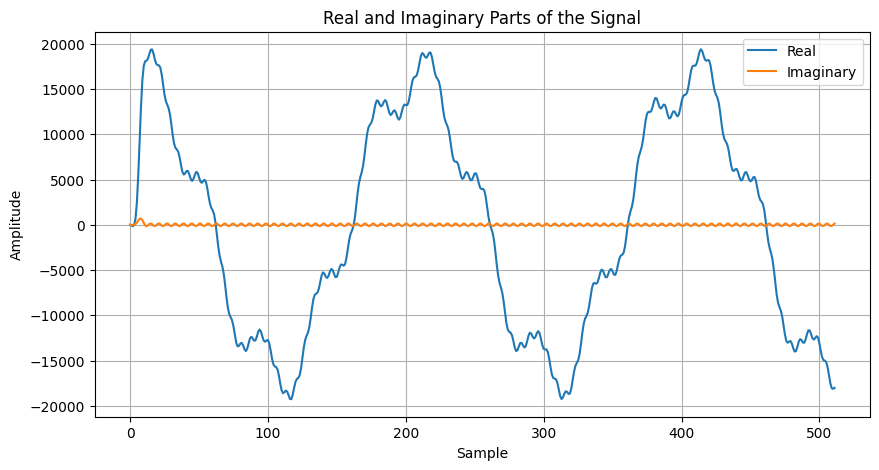

AIE filtered signal


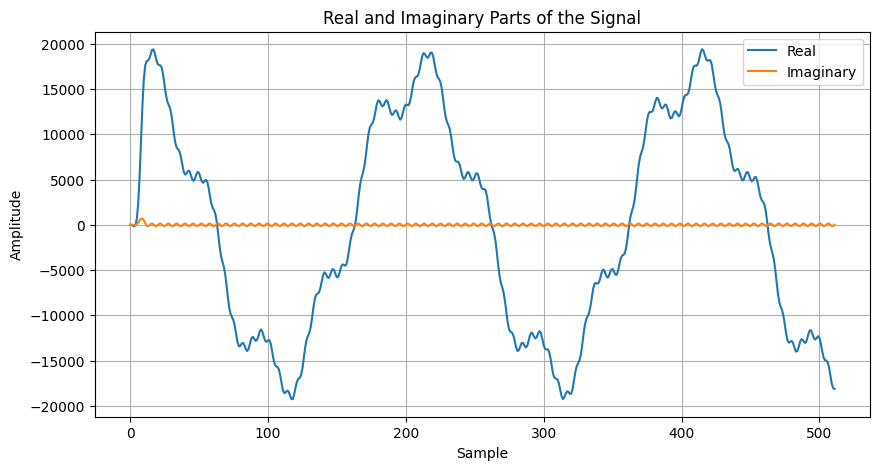

array([False,  True,  True, ...,  True,  True,  True])

In [11]:
print("SW filtered signal")
plotter = SignalPlotter(SW_filtered_signal)
plotter.plot_real_imaginary(512)

print("AIE filtered signal")
AIE_filtered_signal = FileGen().read_file('./data/output.txt', 1024)
plotter = SignalPlotter(AIE_filtered_signal)
plotter.plot_real_imaginary(512)

np.isclose(SW_filtered_signal, AIE_filtered_signal, 10, 10)